In [20]:
import os
import time
import ijson
import numpy as np
import datetime
from datetime import timezone, timedelta
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import unary_union

# For interactive plots (if needed)
%matplotlib widget



In [6]:
def get_all_trajectories(
    file_path, 
    traj_threshold_seconds=10,
    direction=-1,
):
    found_trajectory = []
    date = None
    got_date = False

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)
        
        for record in parser:
            if record["direction"] == direction and (record["last_timestamp"] - record["first_timestamp"] > traj_threshold_seconds):

                #get date of file 
                if not got_date:
                    date = datetime.datetime.fromtimestamp(record["first_timestamp"]).date()
                    got_date = True

                x_pos = np.array(record["x_position"])
                timestamp = np.array(record["timestamp"])

                #calc speed
                speed = np.diff(record["x_position"]) / np.diff(record["timestamp"]) * direction
                speed = np.append(speed[0], speed)
                speed *= 0.681818  # convert ft/s to mph

                # Mask slow speeds
                mask = (speed > 0) & (speed <= 20)

                if np.any(mask):
                    indices = np.where(mask)[0]
                    first_idx = indices[0]
                    last_idx = indices[-1]

                    record["x_position"] = [x_pos[first_idx], x_pos[last_idx]]
                    record["timestamp"] = [timestamp[first_idx], timestamp[last_idx]]
                    record["speed_mph"] = [speed[first_idx], speed[last_idx]]

                    found_trajectory.append(record)
                

    print(f"{file_path}, {date} → Found {len(found_trajectory)} congested trajectories")
    return found_trajectory, date



                

In [7]:
def extract_congested_trajectories(
    file_path, 
    traj_threshold_seconds=10,
    direction=-1,
    speed_thresh=20,
):
    found_trajectory = []
    date = None
    got_date = False

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)
        
        for record in parser:
            if record["direction"] == direction and (record["last_timestamp"] - record["first_timestamp"] > traj_threshold_seconds):

                #get date of file 
                if not got_date:
                    date = datetime.datetime.fromtimestamp(record["first_timestamp"]).date()
                    got_date = True

                x_pos = np.array(record["x_position"])
                timestamp = np.array(record["timestamp"])

                #calc speed
                speed = np.diff(record["x_position"]) / np.diff(record["timestamp"]) * direction
                speed = np.append(speed[0], speed)
                speed *= 0.681818  # convert ft/s to mph

                # Mask slow speeds
                mask = (speed > 0) & (speed <= speed_thresh)

                if np.any(mask):
                    indices = np.where(mask)[0]
                    first_idx = indices[0]
                    last_idx = indices[-1]

                    record["x_position"] = [x_pos[first_idx], x_pos[last_idx]]
                    record["timestamp"] = [timestamp[first_idx], timestamp[last_idx]]
                    record["speed_mph"] = [speed[first_idx], speed[last_idx]]

                    found_trajectory.append(record)
                

    print(f"{file_path}, {date} → Found {len(found_trajectory)} congested trajectories")
    return found_trajectory, date



                

In [10]:
file_path2 = "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json"
trajs2, date2 = extract_congested_trajectories(file_path2)

/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 87695 congested trajectories


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Plotted 6000 trajectories
Plotted 7000 trajectories
Plotted 8000 trajectories
Plotted 9000 trajectories
Plotted 10000 trajectories
Elapsed: 66.5 seconds


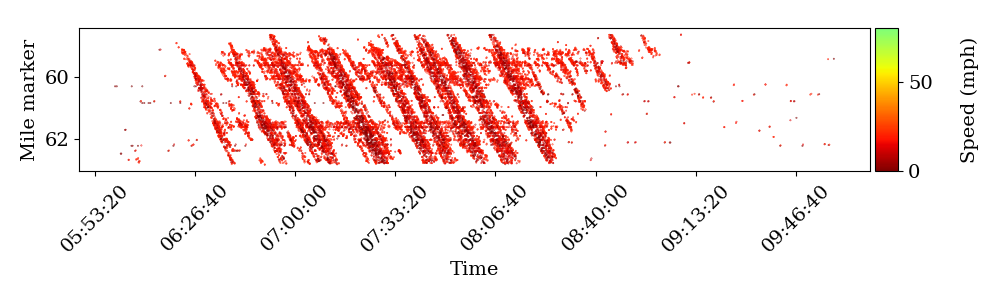

In [11]:
plot_congestion(trajs2, 10000)

In [9]:
def group_trajectories_by_time(trajectories, max_gap_seconds=600):
    """
    Split sorted trajectories into groups where the gap between 
    consecutive trajectories is <= max_gap_seconds.
    """
    # Sort trajectories by first timestamp
    sorted_trajs = sorted(trajectories, key=lambda t: t["first_timestamp"])
    
    groups = []
    current_group = [sorted_trajs[0]]

    for prev_traj, curr_traj in zip(sorted_trajs, sorted_trajs[1:]):
        gap = curr_traj["first_timestamp"] - prev_traj["first_timestamp"]
        if gap <= max_gap_seconds:
            current_group.append(curr_traj)
        else:
            groups.append(current_group)
            current_group = [curr_traj]

    groups.append(current_group)
    return groups



In [ ]:


def plot_congestion(found_trajectory, num_of_traj_to_plot=5000, polygons=None):
    # Get min and max timestamp across all trajectories
    all_start_times = np.array([traj["first_timestamp"] for traj in found_trajectory])
    start_time = all_start_times.min()
    end_time = all_start_times.max()

    max_trajs = num_of_traj_to_plot
    total_trajs = len(found_trajectory)

    if total_trajs <= max_trajs:
        sampled_trajectories = found_trajectory
    else:
        indices = np.linspace(0, total_trajs - 1, max_trajs, dtype=int)
        sampled_trajectories = [found_trajectory[i] for i in indices]

    # Set up plot
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Define colormap
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    print("Plotting sampled trajectories...")
    t0 = time.time()

    for i, traj in enumerate(sampled_trajectories):
        position = np.array(traj["x_position"]) / 5280
        speed = np.array(traj["speed_mph"])
        timestamps = np.array(traj["timestamp"])

        im = ax.scatter(timestamps, position, c=speed, cmap=green_to_red, vmin=0, vmax=80, s=0.1)

        if len(sampled_trajectories) > 999:
            if (i + 1) % 1000 == 0:
                print(f"Plotted {i + 1} trajectories")
        else: 
            if (i + 1) % 100 == 0:
                print(f"Plotted {i + 1} trajectories")

    print(f"Elapsed: {time.time() - t0:.1f} seconds")

    # Colorbar and labels
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # Timestamp formatting (UTC-6)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_datetime = [datetime.datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    # Invert y-axis for westbound direction
    ax.invert_yaxis()

    # --- 🟥 Draw polygons if any ---
    if polygons is not None:
        print(f"Plotting {len(polygons)} congestion polygons...")
        for poly in polygons:
            coords = np.array(poly.exterior.coords)
            ax.add_patch(MplPolygon(
            coords, 
            facecolor='none', 
            edgecolor=mcolors.to_rgba('blue', alpha=0.9), 
        ))

    plt.tight_layout()
    plt.show()


In [51]:
def build_connected_polygons_from_groups(groups, max_gap_feet=1000):
    all_polygons = []

    for group in groups:
        group_polygons = []

        if len(group) < 2:
            continue

        for i in range(len(group) - 1):
            traj_a = group[i]
            traj_b = group[i + 1]

            x_a_end = traj_a["x_position"][-1]
            x_b_start = traj_b["x_position"][0]

            if abs(x_b_start - x_a_end) > max_gap_feet:
                continue

            a_start = (traj_a["timestamp"][0], traj_a["x_position"][0] / 5280)
            b_start = (traj_b["timestamp"][0], traj_b["x_position"][0] / 5280)
            b_end   = (traj_b["timestamp"][-1], traj_b["x_position"][-1] / 5280)
            a_end   = (traj_a["timestamp"][-1], traj_a["x_position"][-1] / 5280)

            poly_points = [a_start, b_start, b_end, a_end]
            poly = Polygon(poly_points)

            if poly.is_valid and poly.area > 0:
                group_polygons.append(poly)

        if group_polygons:
            merged = unary_union(group_polygons)

            if isinstance(merged, MultiPolygon):
                all_polygons.extend(list(merged.geoms))
            else:
                all_polygons.append(merged)

    return all_polygons


In [45]:
def filter_polygons_and_trajectories(polygons, trajectories, min_points=10):
    """
    Filter out polygons with too few points AND remove trajectories not overlapping any kept polygon.
    """
    # Convert all points from trajectories
    points = []
    for traj in trajectories:
        ts = traj["timestamp"]
        xs = [x / 5280 for x in traj["x_position"]]
        points.extend([Point(t, x) for t, x in zip(ts, xs)])

    # Count points in each polygon
    polygon_point_counts = []
    for poly in polygons:
        count = sum(poly.contains(pt) for pt in points)
        if count >= min_points:
            polygon_point_counts.append((poly, count))

    # Keep polygons that have enough points
    kept_polygons = [poly for poly, count in polygon_point_counts]

    # Filter trajectories that intersect with any kept polygon
    kept_trajectories = []
    for traj in trajectories:
        ts = traj["timestamp"]
        xs = [x / 5280 for x in traj["x_position"]]
        traj_points = [Point(t, x) for t, x in zip(ts, xs)]

        # Keep trajectory if any point intersects any kept polygon
        if any(any(poly.contains(p) for poly in kept_polygons) for p in traj_points):
            kept_trajectories.append(traj)

    return kept_polygons, kept_trajectories



Step 1 - Grouping trajectories: 0.11 seconds
Step 2 - Building polygons: 0.73 seconds
Step 3 - Filtering polygons and trajectories: 605.04 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 13.6 seconds
Plotting 89 congestion polygons...


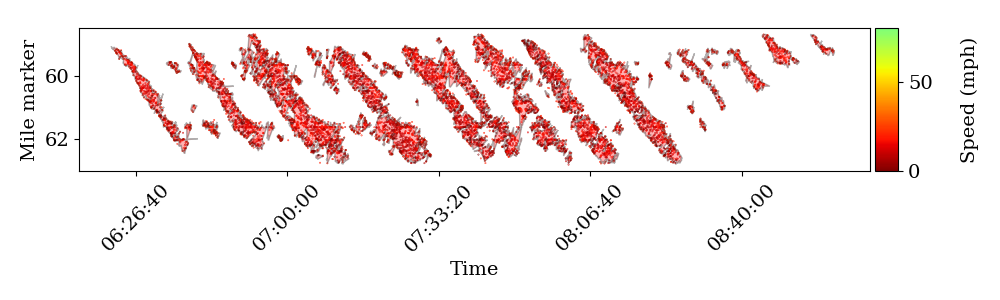

Step 4 - Plotting: 14.77 seconds
Total pipeline time: 620.66 seconds


In [77]:
# Start overall timer
t_total = time.time()

# Step 1: Group trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs2, max_gap_seconds=30)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=500)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories(polygons, trajs2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results
t3 = time.time()
plot_congestion(filt_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


In [81]:
file_path2 = "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json"
trajs_heavy2, date_heavy2 = extract_congested_trajectories(file_path2, speed_thresh=10)

/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 49352 congested trajectories


Step 1 - Grouping trajectories: 0.45 seconds
Step 2 - Building polygons: 0.62 seconds
Step 3 - Filtering polygons and trajectories: 277.23 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 13.7 seconds
Plotting 68 congestion polygons...


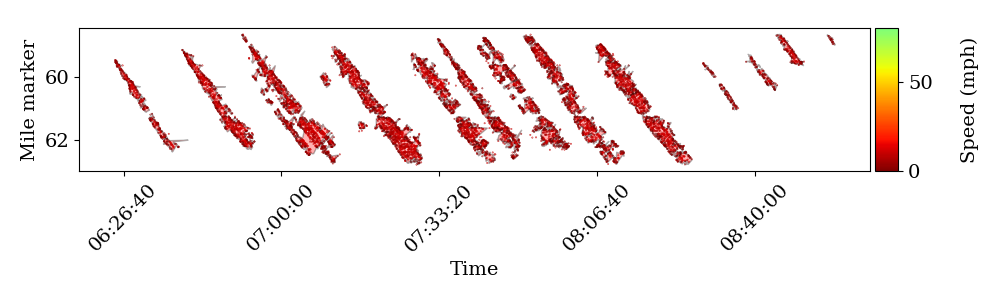

Step 4 - Plotting: 14.78 seconds
Total pipeline time: 293.08 seconds


In [82]:
# Start overall timer
t_total = time.time()

# Step 1: Group trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs_heavy2, max_gap_seconds=30)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=500)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories(polygons, trajs_heavy2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results
t3 = time.time()
plot_congestion(filt_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


In [83]:
file_path2 = "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json"
trajs_super_heavy2, date_super_heavy2 = extract_congested_trajectories(file_path2, speed_thresh=5)

/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 34791 congested trajectories


Step 1 - Grouping trajectories: 0.30 seconds
Step 2 - Building polygons: 0.64 seconds
Step 3 - Filtering polygons and trajectories: 187.45 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 39.8 seconds
Plotting 68 congestion polygons...


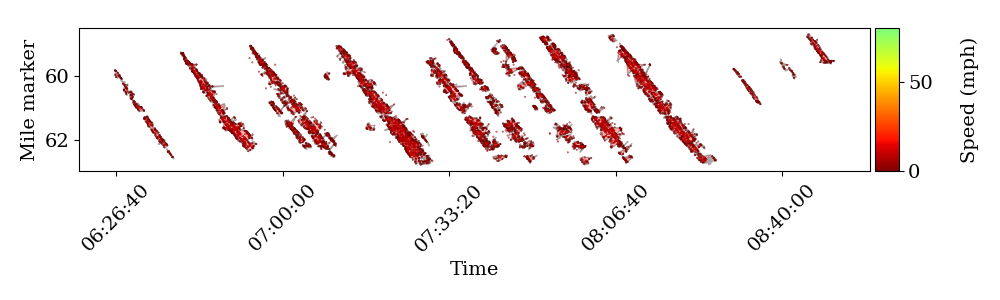

Step 4 - Plotting: 40.94 seconds
Total pipeline time: 229.33 seconds


In [84]:
# Start overall timer
t_total = time.time()

# Step 1: Group trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs_super_heavy2, max_gap_seconds=30)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=500)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories(polygons, trajs_super_heavy2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results
t3 = time.time()
plot_congestion(filt_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


In [13]:
def filter_polygons_and_trajectories_new(polygons, trajectories, min_points=50):
    """
    Keep only polygons that contain >= `min_points` points.
    Also keep only trajectories that fall inside one of those polygons
    and have at least 2 points.
    """


    point_to_traj_id = {}
    traj_id_to_traj = {}
    all_points = []

    for traj in trajectories:
        if len(traj["x_position"]) <= 1:
            continue  # skip single-point trajectories

        ts = traj["timestamp"]
        xs = [x / 5280 for x in traj["x_position"]]
        traj_id = id(traj)
        traj_id_to_traj[traj_id] = traj

        for t, x in zip(ts, xs):
            pt = Point(t, x)
            point_to_traj_id[pt] = traj_id
            all_points.append(pt)

    filtered_polygons = []
    valid_traj_ids = set()

    for poly in polygons:
        contained_points = [pt for pt in all_points if poly.contains(pt)]
        if len(contained_points) >= min_points:
            filtered_polygons.append(poly)
            valid_traj_ids.update([point_to_traj_id[pt] for pt in contained_points])

    # Map back to actual trajectory objects
    filtered_trajectories = [traj_id_to_traj[tid] for tid in valid_traj_ids]

    return filtered_polygons, filtered_trajectories


Step 1 - Grouping trajectories: 0.68 seconds
Step 2 - Building polygons: 0.29 seconds
Step 3 - Filtering polygons and trajectories: 681.00 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 13.6 seconds
Plotting 153 congestion polygons...


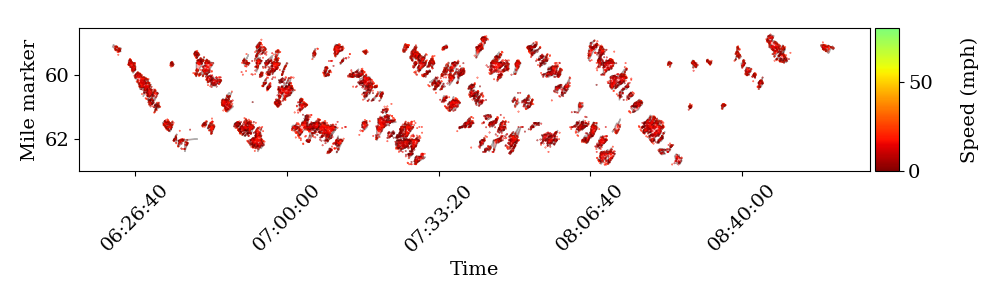

Step 4 - Plotting: 14.87 seconds
Total pipeline time: 696.85 seconds


In [73]:
# Start overall timer
t_total = time.time()

# Step 1: Group trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs2, max_gap_seconds=60)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=100)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories_new(polygons, trajs2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results
t3 = time.time()
plot_congestion(filt_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 13.8 seconds
Plotting 50 congestion polygons...


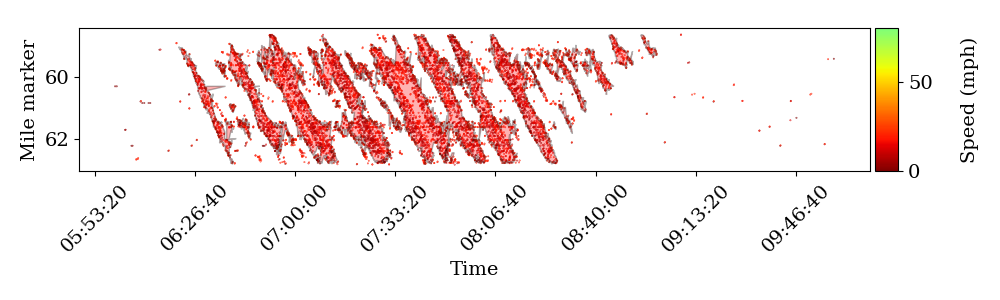

In [60]:
# 1. Group trajectories by time gaps (10 minutes = 600 seconds)
groups = group_trajectories_by_time(trajs2, max_gap_seconds=10)

# 2. Build polygons from those groups
polygons = build_connected_polygons_from_groups(groups)

# 2. Filter polygons based on how many points fall inside
polygons = filter_polygons_by_point_count(polygons, trajs2, min_points=50)

# 3. Plot with polygons
plot_congestion(trajs2, num_of_traj_to_plot=5000, polygons=polygons)

In [45]:
file_path5 = "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json"
trajs5, date5 = extract_congested_trajectories(file_path5)

/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json, 2022-11-25 → Found 1502 congested trajectories


In [14]:
def extract_congested_trajectories(
    file_path, 
    traj_threshold_seconds=10,
    direction=-1,
    speed_thresh=20,
    filter_speed=True,  # new parameter to toggle filtering
):
    found_trajectory = []
    date = None
    got_date = False

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)
        
        for record in parser:
            if record["direction"] == direction and (record["last_timestamp"] - record["first_timestamp"] > traj_threshold_seconds):

                if not got_date:
                    date = datetime.datetime.fromtimestamp(record["first_timestamp"]).date()
                    got_date = True

                x_pos = np.array(record["x_position"])
                timestamp = np.array(record["timestamp"])

                if filter_speed:
                    # Calculate speed
                    speed = np.diff(record["x_position"]) / np.diff(record["timestamp"]) * direction
                    speed = np.append(speed[0], speed)
                    speed *= 0.681818  # ft/s to mph

                    # Mask slow speeds
                    mask = (speed > 0) & (speed <= speed_thresh)

                    if np.any(mask):
                        indices = np.where(mask)[0]
                        first_idx = indices[0]
                        last_idx = indices[-1]

                        record["x_position"] = [x_pos[first_idx], x_pos[last_idx]]
                        record["timestamp"] = [timestamp[first_idx], timestamp[last_idx]]
                        record["speed_mph"] = [speed[first_idx], speed[last_idx]]

                        found_trajectory.append(record)
                else:
                    # No filtering, keep entire trajectory but just add speed_mph for completeness
                    speed = np.diff(record["x_position"]) / np.diff(record["timestamp"]) * direction
                    speed = np.append(speed[0], speed)
                    speed *= 0.681818
                    record["speed_mph"] = speed.tolist()
                    found_trajectory.append(record)
                

    print(f"{file_path}, {date} → Found {len(found_trajectory)} trajectories (filter_speed={filter_speed})")
    return found_trajectory, date


In [16]:
file_path2 = "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json"

/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 265905 trajectories (filter_speed=False)
Step -1 - Extracting all trajectories: 157.48 seconds
/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 87695 trajectories (filter_speed=True)
Step 0 - Extracting filtered trajectories: 204.00 seconds
Step 1 - Grouping trajectories: 0.53 seconds
Step 2 - Building polygons: 0.81 seconds
Step 3 - Filtering polygons and trajectories: 696.01 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 127.3 seconds
Plotting 89 congestion polygons...


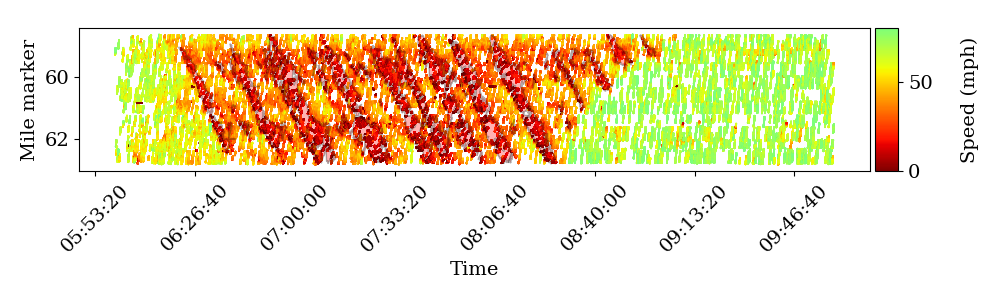

Step 4 - Plotting: 169.40 seconds
Total pipeline time: 1228.24 seconds


In [17]:
# Start overall timer
t_total = time.time()

# Extract all trajectories (no filtering)
t_minus1 = time.time()
all_trajs, _ = extract_congested_trajectories(file_path2, filter_speed=False)
print(f"Step -1 - Extracting all trajectories: {time.time() - t_minus1:.2f} seconds")

# Extract filtered trajectories (with speed filtering)
t_minus0 = time.time()
trajs2, date2 = extract_congested_trajectories(file_path2, filter_speed=True)
print(f"Step 0 - Extracting filtered trajectories: {time.time() - t_minus0:.2f} seconds")

# Step 1: Group filtered trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs2, max_gap_seconds=30)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=500)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories(polygons, trajs2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results using filtered polygons and all trajectories
t3 = time.time()
plot_congestion(all_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Plotted 6000 trajectories
Plotted 7000 trajectories
Plotted 8000 trajectories
Plotted 9000 trajectories
Plotted 10000 trajectories
Elapsed: 195.3 seconds
Plotting 89 congestion polygons...


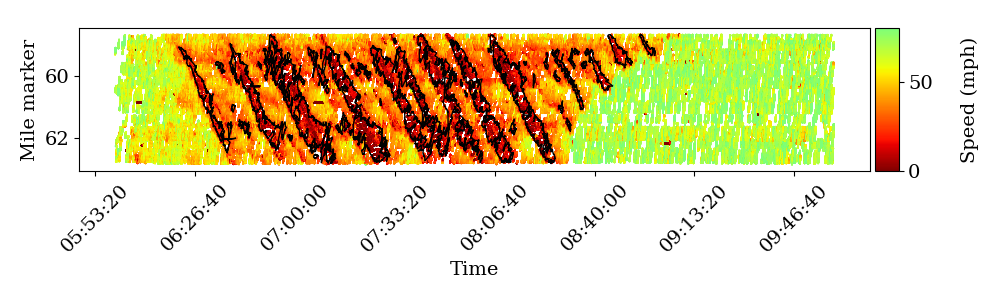

In [25]:
plot_congestion(all_trajs, num_of_traj_to_plot=10000, polygons=filt_polygons)

Step 1 - Grouping trajectories: 1.14 seconds
Step 2 - Building polygons: 0.91 seconds
Step 3 - Filtering polygons and trajectories: 609.47 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 22.9 seconds
Plotting 90 congestion polygons...


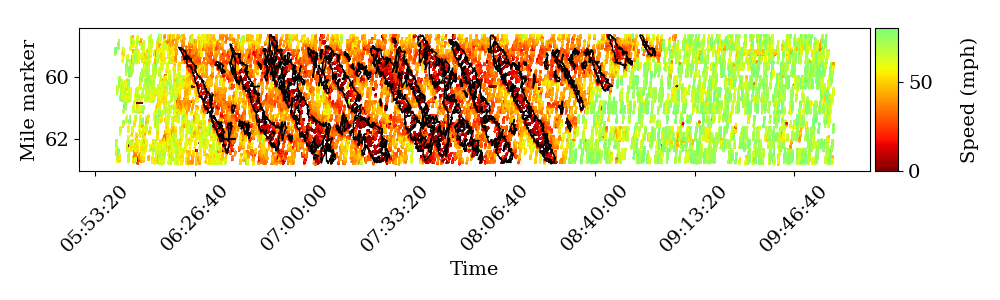

Step 4 - Plotting: 73.45 seconds
Total pipeline time: 684.97 seconds


In [31]:
# Start overall timer
t_total = time.time()


# Step 1: Group filtered trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs2, max_gap_seconds=60)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups(groups, max_gap_feet=500)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories(polygons, trajs2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results using filtered polygons and all trajectories
t3 = time.time()
plot_congestion(all_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")


getting there

In [36]:
from shapely.geometry import Point
from shapely.strtree import STRtree

def filter_polygons_and_trajectories_fast(polygons, trajectories, min_points=50):
    """
    Filter polygons and trajectories using spatial index with STRtree.
    """
    # Build spatial index and keep list of polygons
    tree = STRtree(polygons)

    # STRtree.query returns polygon indices, so we map idx->polygon
    idx_to_poly = dict(enumerate(polygons))

    points = []
    point_to_traj = []
    for i, traj in enumerate(trajectories):
        ts = traj["timestamp"]
        xs = [x / 5280 for x in traj["x_position"]]
        for t, x in zip(ts, xs):
            points.append(Point(t, x))
            point_to_traj.append(i)

    polygon_to_trajs = {poly: set() for poly in polygons}

    for pt, traj_idx in zip(points, point_to_traj):
        # Query returns polygon indices
        candidate_idxs = tree.query(pt)
        for idx in candidate_idxs:
            poly = idx_to_poly[idx]
            if poly.contains(pt):
                polygon_to_trajs[poly].add(traj_idx)

    filtered_polygons = []
    valid_trajs = set()
    for poly, traj_indices in polygon_to_trajs.items():
        if len(traj_indices) >= min_points:
            filtered_polygons.append(poly)
            valid_trajs.update(traj_indices)

    filtered_trajectories = [trajectories[i] for i in valid_trajs]

    return filtered_polygons, filtered_trajectories


In [52]:
def build_connected_polygons_from_groups_simplified(groups, max_gap_feet=1000, simplify_tolerance=0.01):
    all_polygons = []

    for group in groups:
        group_polygons = []

        if len(group) < 2:
            continue

        for i in range(len(group) - 1):
            traj_a = group[i]
            traj_b = group[i + 1]

            x_a_end = traj_a["x_position"][-1]
            x_b_start = traj_b["x_position"][0]

            if abs(x_b_start - x_a_end) > max_gap_feet:
                continue

            a_start = (traj_a["timestamp"][0], traj_a["x_position"][0] / 5280)
            b_start = (traj_b["timestamp"][0], traj_b["x_position"][0] / 5280)
            b_end   = (traj_b["timestamp"][-1], traj_b["x_position"][-1] / 5280)
            a_end   = (traj_a["timestamp"][-1], traj_a["x_position"][-1] / 5280)

            poly_points = [a_start, b_start, b_end, a_end]
            poly = Polygon(poly_points)

            if poly.is_valid and poly.area > 0:
                group_polygons.append(poly)

        if group_polygons:
            merged = unary_union(group_polygons)
            simplified = merged.simplify(simplify_tolerance, preserve_topology=True)

            if isinstance(simplified, MultiPolygon):
                all_polygons.extend(list(simplified.geoms))
            else:
                all_polygons.append(simplified)

    return all_polygons


Step 1 - Grouping trajectories: 0.89 seconds
Step 2 - Building polygons: 1.09 seconds
Step 3 - Filtering polygons and trajectories: 3.47 seconds
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 175.7 seconds
Plotting 66 congestion polygons...


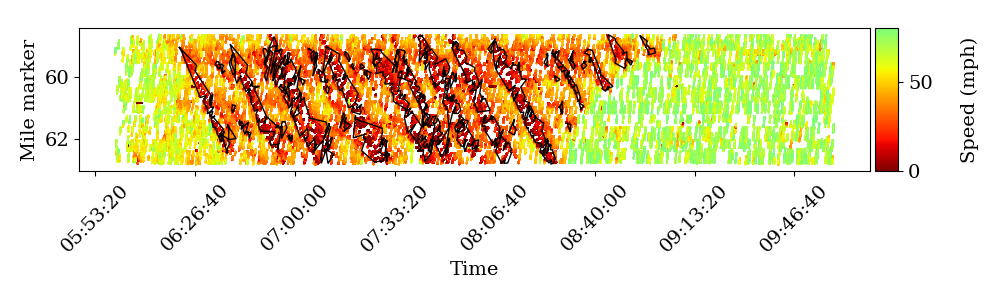

Step 4 - Plotting: 194.28 seconds
Total pipeline time: 199.73 seconds


In [54]:
# Start overall timer
t_total = time.time()


# Step 1: Group filtered trajectories
t0 = time.time()
groups = group_trajectories_by_time(trajs2, max_gap_seconds=60)
print(f"Step 1 - Grouping trajectories: {time.time() - t0:.2f} seconds")

# Step 2: Build polygons from groups
t1 = time.time()
polygons = build_connected_polygons_from_groups_simplified(groups, max_gap_feet=500, simplify_tolerance=0.5)
print(f"Step 2 - Building polygons: {time.time() - t1:.2f} seconds")

# Step 3: Filter polygons and trajectories
t2 = time.time()
filt_polygons, filt_trajs = filter_polygons_and_trajectories_fast(polygons, trajs2, min_points=50)
print(f"Step 3 - Filtering polygons and trajectories: {time.time() - t2:.2f} seconds")

# Step 4: Plot results using filtered polygons and all trajectories
t3 = time.time()
plot_congestion(all_trajs, num_of_traj_to_plot=5000, polygons=filt_polygons)
print(f"Step 4 - Plotting: {time.time() - t3:.2f} seconds")

print(f"Total pipeline time: {time.time() - t_total:.2f} seconds")
